In [1]:
!pip install "opencv-python-headless<4.3" #cv2のバージョンを4.3以下でダウンロードする、augmentationでバグが起きるからフォルダごとに考える必要がある
!pip install albumentations==1.1.0 #augmentationのライブラリ（画像を増やす）

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 MB 28.9 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 4.8.0.74
    Uninstalling opencv-python-headless-4.8.0.74:
      Successfully uninstalled opencv-python-headless-4.8.0.74
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 1.2.1 requires opencv-python-headless>=4.1.1, but you have opencv-python-headless 3.4.18.65 which is incompatible.
qudida 0.0.4 requires opencv-python-headless>=4.0.1, but you have opencv-python-headless 3.4.18.65 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.4/102.4 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 14.1 MB/s eta 0:00:00
  Attempting uninstall: opencv-python-headless
    Found existing installation: opencv-python-headless 3.

In [2]:
import pandas as pd
import numpy as np
import glob
import cv2
from google.colab.patches import cv2_imshow
import datetime
t_delta = datetime.timedelta(hours=9)
JST = datetime.timezone(t_delta, 'JST')
import random

import torch #ML
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torch.utils.data.dataset import Subset

import albumentations as A #augmentation(増強)
from albumentations.pytorch import ToTensorV2

from tqdm.notebook import tqdm, trange #残り何秒か分かる
from typing import OrderedDict #辞書型に順番を決める
from sklearn.model_selection import KFold

from google.colab import drive
drive.mount('/content/drive')

DIR_PATH="/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/01.学習データ"

Mounted at /content/drive


In [3]:
patch_size = 112

In [4]:
def make_augmentations(W=patch_size, H=patch_size, crop_size=patch_size):
    augmentations_dict = {
        "random_crop":A.Compose(
            [
                A.RandomCrop(width=crop_size, height=crop_size),
            ]
        ),
        "vertical_flip": A.Compose(
            [
                A.VerticalFlip(p=1.0),
            ]
        ),
        "horizontal_flip":A.Compose(
            [
                A.HorizontalFlip(p=1.0),
            ]
        ),
        "normallize": A.Compose(
            [
                ToTensorV2(),
            ]
        ),
    }
    return augmentations_dict

In [5]:
class Transform(object):
    def __init__(self,augmentations_dict=make_augmentations()):
        self.augmentations_dict=augmentations_dict

    def __call__(self, image):
        if self.augmentations_dict is not None:
          image = self.augmentations_dict["normallize"](image=image)["image"]
          image = image/255
        return image

class Transform_horizontal(object):
    def __init__(self,augmentations_dict=make_augmentations()):
        self.augmentations_dict=augmentations_dict

    def __call__(self, image):
        if self.augmentations_dict is not None:
          image = self.augmentations_dict["horizontal_flip"](image=image)["image"]
          image = self.augmentations_dict["normallize"](image=image)["image"]
          image = image/255
        return image

class Transform_vertical(object):
    def __init__(self,augmentations_dict=make_augmentations()):
        self.augmentations_dict=augmentations_dict

    def __call__(self, image):
        if self.augmentations_dict is not None:
          image = self.augmentations_dict["vertical_flip"](image=image)["image"]
          image = self.augmentations_dict["normallize"](image=image)["image"]
          image = image/255
        return image

class Transform_inverted(object):
    def __init__(self,augmentations_dict=make_augmentations()):
        self.augmentations_dict=augmentations_dict

    def __call__(self, image):
        if self.augmentations_dict is not None:
          image = self.augmentations_dict["horizontal_flip"](image=image)["image"]
          image = self.augmentations_dict["vertical_flip"](image=image)["image"]
          image = self.augmentations_dict["normallize"](image=image)["image"]
          image = image/255
        return image

In [6]:
sample_paths=glob.glob(f"{DIR_PATH}/*")
sample_paths

for path in tqdm(sample_paths):
  sample_name=path.split("/")[-1]

  path_dict={
      key:f"{sample_name}/{sample_name}_{key}.bmp"
      for key in ["BC","GB","IPF"]
  }
  print(path_dict)
  image = np.dstack([cv2.imread(path) for path in path_dict.values()])

  0%|          | 0/5 [00:00<?, ?it/s]

{'BC': 'HGE15/HGE15_BC.bmp', 'GB': 'HGE15/HGE15_GB.bmp', 'IPF': 'HGE15/HGE15_IPF.bmp'}
{'BC': 'HGE20/HGE20_BC.bmp', 'GB': 'HGE20/HGE20_GB.bmp', 'IPF': 'HGE20/HGE20_IPF.bmp'}
{'BC': 'HGE16/HGE16_BC.bmp', 'GB': 'HGE16/HGE16_GB.bmp', 'IPF': 'HGE16/HGE16_IPF.bmp'}
{'BC': 'HGE22/HGE22_BC.bmp', 'GB': 'HGE22/HGE22_GB.bmp', 'IPF': 'HGE22/HGE22_IPF.bmp'}
{'BC': 'HGE21/HGE21_BC.bmp', 'GB': 'HGE21/HGE21_GB.bmp', 'IPF': 'HGE21/HGE21_IPF.bmp'}


In [7]:
class CustomDataset(torch.utils.data.Dataset):
  def __init__(self,transform):
    self.transform = transform
    self.images = []
    self.labels = []
    self.mu_range = [1e20,0]
    self.n_range = [1e20,0]
    self.conditions = []
    sample_paths=glob.glob(f"{DIR_PATH}/*")

    for path in tqdm(sample_paths):
      sample_name=path.split("/")[-1]

      path_dict={
      key:f"{DIR_PATH}/{sample_name}/{sample_name}_{key}.bmp"
        for key in ["BC","GB","IPF"]
      }
      print(path_dict)
      image = np.dstack([cv2.imread(path) for path in path_dict.values()])

      path_dict["Hall"]=f"{DIR_PATH}/{sample_name}/{sample_name}_Hall.csv" #DFに一列だけ追加するみたいなもん
      Hall=pd.read_csv(path_dict["Hall"])
      mu=Hall["Mobility [cm²/(V·s)]"].tolist()
      n=Hall["Carrier Concentration [1/cm³]"].tolist()

      if self.mu_range[0] > np.min(mu):
        self.mu_range[0] = np.min(mu)
      if self.mu_range[1] < np.max(mu):
        self.mu_range[1] = np.max(mu)

      if self.n_range[0] > np.min(n):
        self.n_range[0] = np.min(n)
      if self.n_range[1] < np.max(n):
        self.n_range[1] = np.max(n) # imageは結合した画像

      H,W,_ = image.shape #3変数返ってくるので
      n_H, n_W = H//patch_size, W//patch_size
      H_, W_ = patch_size*n_H, patch_size*n_W
      image = image[:H_, :W_]

      for h in np.vsplit(image, n_H):
        for w in np.hsplit(h, n_W):
          self.images.append(w)
          label=[random.choice(mu),random.choice(n)]
          self.labels.append(label)

    self.labels=np.array(self.labels)
    self.labels=(self.labels-np.min(self.labels,axis=0))/(np.max(self.labels,axis=0)-np.min(self.labels,axis=0))

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    #idxは番号
    image=self.images[idx]#np.array
    image=self.transform(image)#tensor
    image=image.to(torch.float32)#tensorのfloat32

    label=self.labels[idx]#np.array
    label=torch.Tensor(label)#Tensor
    label=label.to(torch.float32)
    return image, label

In [8]:
from torchvision import models
class ResNetBaseModel(nn.Module):
  def __init__(
       self,
       num_layer: int,
       pretrained: bool = True,
       is_BC=True,
       is_GB=True,
       is_IPF=True,
    ):
       super().__init__()
       if num_layer in [18, 34, 50, 101, 152]:
         if num_layer == 18:
            self.resnet = models.resnet18(pretrained=pretrained)
         elif num_layer == 34:
            self.resnet = models.resnet34(pretrained=pretrained)
         elif num_layer == 50:
            self.resnet = models.resnet50(pretrained=pretrained)
         elif num_layer == 101:
            self.resnet = models.resnet101(pretrained=pretrained)
         elif num_layer == 152:
            self.resnet = models.resnet152(pretrained=pretrained)
         self.out = nn.Sequential(
             nn.Linear(self.resnet.fc.in_features, 2),
             nn.Sigmoid() #0-1にもってくる
         )
         self.resnet.conv1 = nn.Conv2d(9, 64, kernel_size=7, stride=2, padding=3, bias=False)
         self.resnet.fc = nn.Identity()

       else:
         raise Exception("Invalid number of ResNet layers.")

       self.is_BC=is_BC
       self.is_GB=is_GB
       self.is_IPF=is_IPF


  def forward(self, x):
    x=self.channel_setting(x)
    features = self.resnet(x)
    output = self.out(features)
    return output

  def get_features(self, x):
    features = self.resnet(x)
    return features

  def channel_setting(self,x):
    if not self.is_BC:
      x[:,0] = 0
      x[:,1] = 0
      x[:,2] = 0
    if not self.is_GB:
      x[:,3] = 0
      x[:,4] = 0
      x[:,5] = 0
    if not self.is_IPF:
      x[:,6] = 0
      x[:,7] = 0
      x[:,8] = 0
    return x

  def predict(self, sample_path, device, mu_range, n_range, corner):
    self.eval()
    self.to(device)
    sample_name=sample_path.split("/")[-1]

    path_dict={
        key:f"{sample_path}/{sample_name}_{key}.bmp"
        for key in ["BC","GB","IPF"]
    }
    print(path_dict)

    image = np.dstack([cv2.imread(path) for path in path_dict.values()])
    image=image[corner[0]:corner[0]+patch_size,corner[1]:corner[1]+patch_size]

    aug = A.Compose(
        [
             ToTensorV2(),
         ]
         )

    with torch.no_grad():
      x = aug(image=image)["image"]
      x = x/255
      x = x.unsqueeze(0)
      x = x.to(torch.float32)
      x = x.to(device)
      y = self.forward(x)
      mu = y[0][0].item()*(mu_range[1]-mu_range[0])+mu_range[0]
      n = y[0][1].item()*(n_range[1]-n_range[0])+n_range[0]
      return mu, n

In [9]:
trans = Transform(augmentations_dict=make_augmentations())
trainval_dataset = CustomDataset(trans)
mu_range = trainval_dataset.mu_range
n_range = trainval_dataset.n_range

trans = Transform_horizontal(augmentations_dict=make_augmentations())
trainval_dataset += CustomDataset(trans)

trans = Transform_vertical(augmentations_dict=make_augmentations())
trainval_dataset += CustomDataset(trans)

trans = Transform_inverted(augmentations_dict=make_augmentations())
trainval_dataset += CustomDataset(trans)
#一回やれば一時保存されるので早い（キャッシュっていうらしい）

  0%|          | 0/5 [00:00<?, ?it/s]

{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/01.学習データ/HGE15/HGE15_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/01.学習データ/HGE15/HGE15_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/01.学習データ/HGE15/HGE15_IPF.bmp'}
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/01.学習データ/HGE20/HGE20_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/01.学習データ/HGE20/HGE20_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/01.学習データ/HGE20/HGE20_IPF.bmp'}
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/01.学習データ/HGE16/HGE16_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/01.学習データ/HGE16/HGE16_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/01.学習データ/HGE16/HGE16_IPF.bmp'}
{'BC': '/content/drive/MyDrive/03.移動度

  0%|          | 0/5 [00:00<?, ?it/s]

{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/01.学習データ/HGE15/HGE15_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/01.学習データ/HGE15/HGE15_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/01.学習データ/HGE15/HGE15_IPF.bmp'}
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/01.学習データ/HGE20/HGE20_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/01.学習データ/HGE20/HGE20_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/01.学習データ/HGE20/HGE20_IPF.bmp'}
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/01.学習データ/HGE16/HGE16_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/01.学習データ/HGE16/HGE16_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/01.学習データ/HGE16/HGE16_IPF.bmp'}
{'BC': '/content/drive/MyDrive/03.移動度

  0%|          | 0/5 [00:00<?, ?it/s]

{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/01.学習データ/HGE15/HGE15_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/01.学習データ/HGE15/HGE15_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/01.学習データ/HGE15/HGE15_IPF.bmp'}
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/01.学習データ/HGE20/HGE20_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/01.学習データ/HGE20/HGE20_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/01.学習データ/HGE20/HGE20_IPF.bmp'}
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/01.学習データ/HGE16/HGE16_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/01.学習データ/HGE16/HGE16_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/01.学習データ/HGE16/HGE16_IPF.bmp'}
{'BC': '/content/drive/MyDrive/03.移動度

  0%|          | 0/5 [00:00<?, ?it/s]

{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/01.学習データ/HGE15/HGE15_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/01.学習データ/HGE15/HGE15_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/01.学習データ/HGE15/HGE15_IPF.bmp'}
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/01.学習データ/HGE20/HGE20_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/01.学習データ/HGE20/HGE20_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/01.学習データ/HGE20/HGE20_IPF.bmp'}
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/01.学習データ/HGE16/HGE16_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/01.学習データ/HGE16/HGE16_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/01.学習データ/HGE16/HGE16_IPF.bmp'}
{'BC': '/content/drive/MyDrive/03.移動度

In [10]:
count = 0
for i, _ in trainval_dataset:
  count+=1
print(count)

1560


## 本学習

In [13]:
num_start=0
batch_size=32
num_layer = 152
num_epoch=50
random_state=0
lr=5e-5

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.MSELoss()

num_loop=0

kf = KFold(n_splits=5, shuffle=True, random_state=random_state)
for k, (train_idx, valid_idx) in enumerate(kf.split(trainval_dataset)):
  best_loss=1
  if num_loop>=num_start:
    print(f"try_{num_loop}:k={k}")
    train_dataset = Subset(trainval_dataset, train_idx)
    val_dataset   = Subset(trainval_dataset, valid_idx)

    # 学習用Dataloader
    train_dataloader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=16,
        drop_last=True, #8,8,8,3とかが嫌なので3を除く
        pin_memory=True
    )

  # 評価用Dataloader
  valid_dataloader = DataLoader(
      val_dataset,
      batch_size=batch_size,
      shuffle=False,
      num_workers=16,
      drop_last=False,
      pin_memory=True
  )

  model = ResNetBaseModel(num_layer)

  optimizer = torch.optim.Adam(model.parameters(), lr=lr)
  model.to(device)

  train_loss=[]
  valid_loss=[]

  with trange(num_epoch) as pbar:
    for i in pbar:
      pbar.set_description(f'[Epoch {i + 1}/{num_epoch}]')
      model.train()#学習モード
      running_loss=[]

      for image, label in train_dataloader:
        image, label = image.to(device), label.to(device)
        optimizer.zero_grad()
        outputs = model(image)
        loss = criterion(outputs, label)
        loss.backward()
        optimizer.step()
        running_loss.append(loss.item())
      train_loss.append(np.mean(running_loss))

      model.eval()#評価モード
      running_loss=[]
      with torch.no_grad():
        for image, label in valid_dataloader:
          image, label = image.to(device), label.to(device)
          outputs = model(image)
          loss = criterion(outputs, label)
          running_loss.append(loss.item())
      valid_loss.append(np.mean(running_loss))

      pbar.set_postfix(
          OrderedDict(
              TrainLoss=train_loss[-1],
              ValidLoss=valid_loss[-1],
          )
      )
      if best_loss>valid_loss[-1]:
        best_loss=valid_loss[-1]
        torch.save(model.state_dict(), f"/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/ResNet{num_layer}_patch{patch_size}_lr={lr}_k={k}_HAGB+LAGB.pth")
  num_loop+=1
  pd.DataFrame(data={
    "train_loss":train_loss,
    "valid_loss":valid_loss
  }).to_csv(f"/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/ResNet{num_layer}_patch{patch_size}_lr={lr}_k={k}_HAGB+LAGB.csv",index=False)
  print(best_loss)


try_0:k=0


  0%|          | 0/50 [00:00<?, ?it/s]

0.009812521049752831
try_1:k=1


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can a

  0%|          | 0/50 [00:00<?, ?it/s]

0.010401131922844798
try_2:k=2


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 4, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can a

  0%|          | 0/50 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
pd.DataFrame(data={
  "train_loss":train_loss,
  "valid_loss":valid_loss
}).to_csv(f"/content/drive/MyDrive/03.移動度ML/02.本番/02.電特予測/ResNet{num_layer}_patch{patch_size}_lr={lr}_k={k}.csv",index=False)
print(best_loss)

0.007574422112520551


##評価（テストデータ）

In [11]:
model = ResNetBaseModel(152)
model.load_state_dict(torch.load(f'/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/ResNet152_patch112_lr=5e-05_k=0_HAGB+LAGB.pth'))

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:00<00:00, 356MB/s]


<All keys matched successfully>

In [12]:
def list_average(x):
  mob_ave = 0
  n_ave = 0
  for i in range(len(x)):
    mob_ave += x[i][0]
    n_ave   += x[i][1]
  mob_ave = mob_ave/len(x)
  n_ave = n_ave/len(x)

  return mob_ave, n_ave

{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_IPF.bmp'}


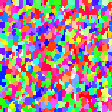

(213.67805118393537, 5.832731720802952e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_IPF.bmp'}


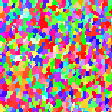

(219.3741685281755, 6.003481462142876e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_IPF.bmp'}


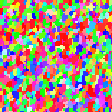

(215.58212845280184, 5.865372846654111e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_IPF.bmp'}


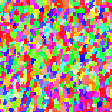

(218.98640310434212, 5.837317579416325e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_IPF.bmp'}


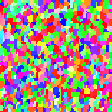

(218.18466504019125, 5.856930178687859e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_IPF.bmp'}


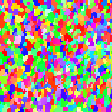

(214.2232160501788, 5.923651528798664e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_IPF.bmp'}


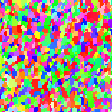

(218.31800706800476, 5.984556923125096e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_IPF.bmp'}


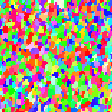

(218.84849444472954, 5.889392831572173e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_IPF.bmp'}


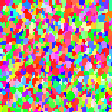

(220.45167186371634, 5.853949082385215e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_IPF.bmp'}


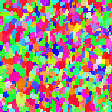

(253.43075297888595, 5.180134643316868e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_IPF.bmp'}


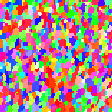

(221.04842292346393, 5.939378284837548e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_IPF.bmp'}


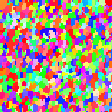

(214.83028389603732, 5.979686276308649e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_IPF.bmp'}


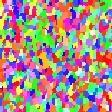

(212.55969708663207, 5.849958845276024e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_IPF.bmp'}


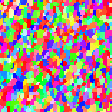

(218.7773382652005, 5.924476646043702e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_IPF.bmp'}


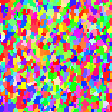

(218.10148581073736, 5.970857415044527e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_IPF.bmp'}


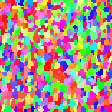

(219.46290782419544, 5.894108702191296e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_IPF.bmp'}


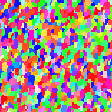

(223.02555498636855, 5.900309783851489e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_IPF.bmp'}


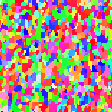

(218.4338813897445, 5.91119385953165e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_IPF.bmp'}


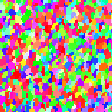

(219.40375885394582, 5.767130523391946e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_IPF.bmp'}


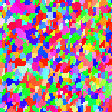

(233.2630631925573, 5.789333755980054e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_IPF.bmp'}


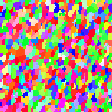

(215.53533971193102, 5.970250692351022e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_IPF.bmp'}


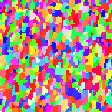

(216.3413434356167, 5.887109188837327e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_IPF.bmp'}


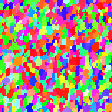

(218.28486164879723, 5.823051270226939e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_IPF.bmp'}


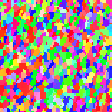

(217.10853531490906, 6.040836110284646e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_IPF.bmp'}


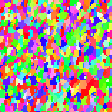

(218.27869963770266, 5.765045634642904e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_IPF.bmp'}


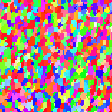

(218.4370517817913, 5.837508220994545e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_IPF.bmp'}


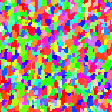

(216.01775299255112, 5.901555465384428e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_IPF.bmp'}


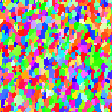

(220.67506569817593, 5.962588309903689e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_IPF.bmp'}


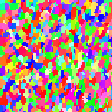

(223.81591494116083, 5.925829710234921e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_IPF.bmp'}


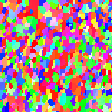

(233.92813043039294, 5.6022494684856896e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_IPF.bmp'}


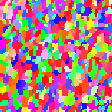

(210.23654422665186, 5.808322126836456e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_IPF.bmp'}


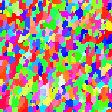

(220.76503377569583, 5.800008403453906e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_IPF.bmp'}


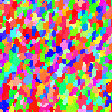

(211.7341143251241, 5.896296703910418e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_IPF.bmp'}


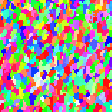

(208.57668558368738, 5.575021666821454e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_IPF.bmp'}


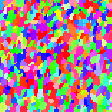

(212.59823737710272, 5.728659565269761e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_IPF.bmp'}


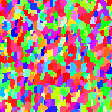

(213.0597047984899, 5.78251719876554e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_IPF.bmp'}


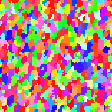

(206.93680652058111, 5.781215370832748e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_IPF.bmp'}


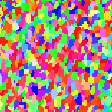

(212.63744297468384, 5.66786069966397e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_IPF.bmp'}


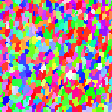

(223.4389053156133, 5.669461832739724e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20/HGE20_IPF.bmp'}


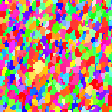

(271.50080186029055, 5.021165185210707e+17)
HGE20:219.99727313236986,5.815012642855246e+17
  sample_name    mobility  Concentration
0     default    0.000000   0.000000e+00
0       HGE20  219.997273   5.815013e+17


In [31]:
path_list = glob.glob('/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/00.データ/02.テストデータ/HGE20')

ans = {'sample_name':'default',
'mobility':0,
'Concentration':0,
}
d3={}
for k,v in ans.items():   # 一度pd.Seriesに変換
  d3[k]=pd.Series(v)
ans=pd.DataFrame(d3)

for path in path_list:
  preds_list = []
  sample_name = path.split('/')[-1]
  for i in range(4):
    for j in range(10):
      preds = model.predict(path,"cuda:0" if torch.cuda.is_available() else "cpu",mu_range, n_range, [50+int(patch_size*i),int(patch_size*j)])
      img = cv2.imread(f'{path}/{sample_name}_IPF.bmp')
      cv2_imshow(img[int(patch_size*i):int(patch_size*i)+patch_size,int(patch_size*j):int(patch_size*j)+patch_size])
      print(preds)
      preds_list.append(preds)
      sample_name = path.split('/')[-1]
  preds_list = pd.DataFrame(preds_list)

  d1 = {'sample_name':sample_name,
  'mobility':preds_list[0].mean(),
    'Concentration': preds_list[1].mean(),
  }

  d2={}
  for k,v in d1.items():   # 一度pd.Seriesに変換
      d2[k]=pd.Series(v)

  df=pd.DataFrame(d2)
  ans = pd.concat([ans,df])
  print(f'{path.split("/")[-1]}:{preds_list[0].mean()},{preds_list[1].mean()}')

  print(ans)

In [32]:
#HGE20
preds_list.describe()

0             1
count   40.000000  4.000000e+01
mean   219.997273  5.815013e+17
std     11.387775  1.970578e+16
min    206.936807  5.021165e+17
25%    214.678517  5.782192e+17
50%    218.301434  5.855440e+17
75%    220.507520  5.923858e+17
max    271.500802  6.040836e+17

In [30]:
#HGE22
preds_list.describe()

0             1
count   40.000000  4.000000e+01
mean   301.464260  4.566354e+17
std     10.600074  4.829623e+16
min    264.814628  3.097712e+17
25%    297.884209  4.625293e+17
50%    301.038365  4.730547e+17
75%    309.010217  4.796297e+17
max    323.148575  4.993159e+17

['/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15', '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20', '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22', '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21', '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16']
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_IPF.bmp'}


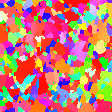

(196.80662321346765, 2.6270919702278074e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_IPF.bmp'}


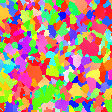

(222.2413344131773, 2.8833294737944634e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_IPF.bmp'}


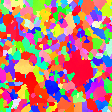

(240.2489236294254, 2.812439787205342e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_IPF.bmp'}


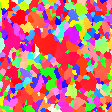

(209.11669205687534, 2.7133257203686966e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_IPF.bmp'}


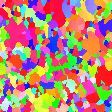

(192.4873908277821, 2.6121424197157197e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_IPF.bmp'}


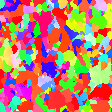

(247.54552321997016, 2.822922138596796e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_IPF.bmp'}


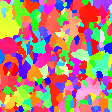

(244.28685804469868, 2.6958797743752723e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_IPF.bmp'}


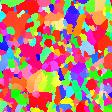

(214.66297273545092, 2.6692968490714605e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_IPF.bmp'}


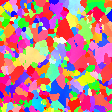

(208.8906403883979, 2.63779592177264e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_IPF.bmp'}


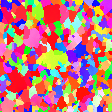

(215.05914275319, 2.6497850377913494e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_IPF.bmp'}


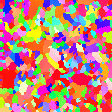

(200.8459759322494, 2.645380250650376e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_IPF.bmp'}


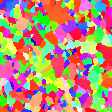

(223.30531662632006, 2.7577070811125603e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_IPF.bmp'}


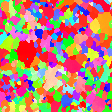

(196.94262986414708, 2.6271676037514736e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_IPF.bmp'}


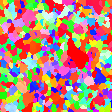

(228.56387008321337, 2.7253285544286022e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_IPF.bmp'}


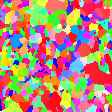

(234.16177542543215, 3.0170222976880544e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_IPF.bmp'}


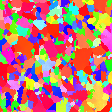

(255.1065258131918, 2.775397746953838e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_IPF.bmp'}


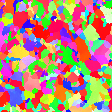

(227.87760127286765, 2.806143344727712e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_IPF.bmp'}


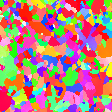

(267.292652920408, 3.5125767472968934e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_IPF.bmp'}


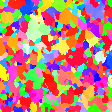

(288.31954836976615, 3.3014003171538515e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_IPF.bmp'}


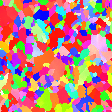

(208.06307980915338, 2.669773966713872e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_IPF.bmp'}


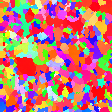

(209.53422884242744, 2.6915605911470554e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_IPF.bmp'}


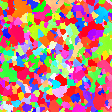

(225.17433175787505, 2.7670155617895248e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_IPF.bmp'}


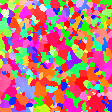

(212.88619541961924, 2.6549017720901514e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_IPF.bmp'}


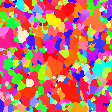

(214.5363991891592, 2.683555759691758e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_IPF.bmp'}


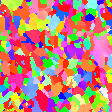

(231.309834663693, 2.838573588010017e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_IPF.bmp'}


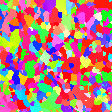

(268.18903884134556, 2.9352466941157357e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_IPF.bmp'}


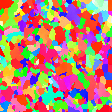

(295.2462372068911, 3.6407682647410496e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_IPF.bmp'}


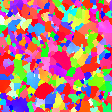

(248.48275990267018, 3.309595610059897e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_IPF.bmp'}


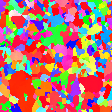

(288.4725961605659, 3.6837251707726803e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_IPF.bmp'}


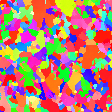

(293.46047145622003, 3.515618259687597e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_IPF.bmp'}


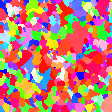

(202.37515207863018, 2.6343305944603248e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_IPF.bmp'}


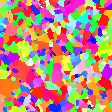

(216.49642561788687, 2.749371649034059e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_IPF.bmp'}


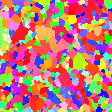

(209.29734217243671, 2.6878671507390067e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_IPF.bmp'}


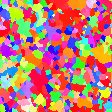

(260.6211116230966, 2.6994450240664432e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_IPF.bmp'}


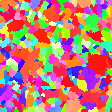

(266.4893149510629, 3.420698767897548e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_IPF.bmp'}


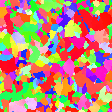

(232.08337411592709, 2.8536260268540467e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_IPF.bmp'}


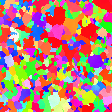

(268.2484638914166, 3.568336313402259e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_IPF.bmp'}


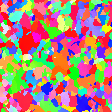

(257.603871462748, 3.213875444989766e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_IPF.bmp'}


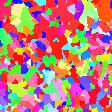

(254.67510357039538, 3.007577240359728e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE15/HGE15_IPF.bmp'}


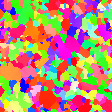

(234.8079968210366, 2.8751367160157872e+17)
HGE15:235.2953831786072,2.90981833008303e+17
  sample_name    mobility  Concentration
0     default    0.000000   0.000000e+00
0       HGE15  235.295383   2.909818e+17
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_IPF.bmp'}


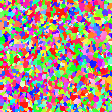

(304.7363136075582, 4.548487858416009e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_IPF.bmp'}


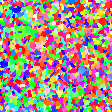

(309.92111980791066, 4.518894436003448e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_IPF.bmp'}


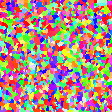

(305.451496121817, 4.646157829974692e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_IPF.bmp'}


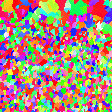

(300.15532565779, 4.517178234830649e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_IPF.bmp'}


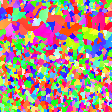

(303.0742678240418, 4.217650534372022e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_IPF.bmp'}


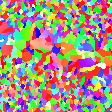

(297.9156846808189, 4.8531435611474586e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_IPF.bmp'}


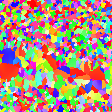

(295.7475619552737, 4.628803895762021e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_IPF.bmp'}


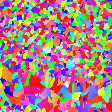

(301.81780592758264, 4.7947162938534746e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_IPF.bmp'}


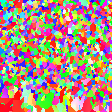

(304.0640456648739, 4.795438298128435e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_IPF.bmp'}


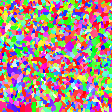

(302.2542202366569, 4.721761625936553e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_IPF.bmp'}


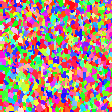

(299.0406149089488, 4.5269009553198624e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_IPF.bmp'}


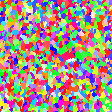

(304.17845133248204, 4.8076419209474285e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_IPF.bmp'}


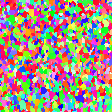

(307.73654996645087, 4.7045037597084275e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_IPF.bmp'}


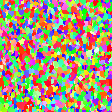

(301.2938516856467, 4.886837165140412e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_IPF.bmp'}


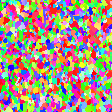

(308.11314094636765, 4.5799157523645645e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_IPF.bmp'}


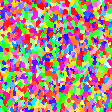

(304.7064064688782, 4.4281351682841325e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_IPF.bmp'}


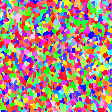

(315.78435822499137, 4.7014801800081715e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_IPF.bmp'}


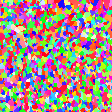

(308.533959008485, 4.6153994231362125e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_IPF.bmp'}


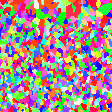

(303.8169496988666, 4.7604338998574637e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_IPF.bmp'}


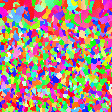

(305.77956946755546, 4.68879066667179e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_IPF.bmp'}


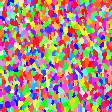

(304.44224786473166, 4.728109157902075e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_IPF.bmp'}


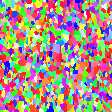

(307.40551668295564, 4.821418496900043e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_IPF.bmp'}


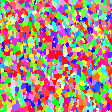

(302.7976811020358, 4.620262171029485e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_IPF.bmp'}


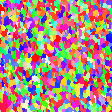

(305.22521023808133, 4.366096064997861e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_IPF.bmp'}


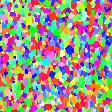

(297.07794988127284, 4.7029869529746624e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_IPF.bmp'}


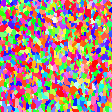

(307.3295539989959, 4.6315095971756365e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_IPF.bmp'}


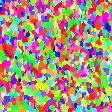

(303.76295572724837, 4.844714983152275e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_IPF.bmp'}


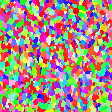

(312.510893360936, 4.845298863013901e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_IPF.bmp'}


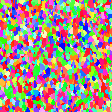

(304.68659208432285, 4.7219048739757306e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_IPF.bmp'}


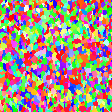

(307.5472859341684, 4.78450298618985e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_IPF.bmp'}


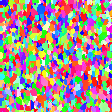

(305.0773310236092, 4.716555595111839e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_IPF.bmp'}


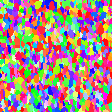

(303.44521953416506, 4.883336234299172e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_IPF.bmp'}


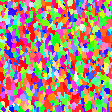

(314.3135497655952, 4.577229478032268e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_IPF.bmp'}


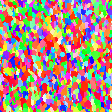

(305.5408102069732, 4.7471777988966746e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_IPF.bmp'}


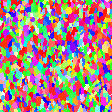

(306.8686726814918, 4.757480556528132e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_IPF.bmp'}


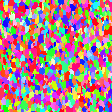

(306.0043708565141, 4.820613874158373e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_IPF.bmp'}


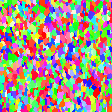

(301.30679575595923, 4.5618600948958925e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_IPF.bmp'}


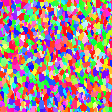

(304.75755817610604, 4.616060157385473e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_IPF.bmp'}


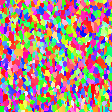

(308.0870084072123, 4.646700507345168e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE20/HGE20_IPF.bmp'}


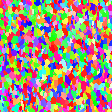

(306.23506496559395, 4.8429101859492845e+17)
HGE20:304.96359903602416,4.6794750022444256e+17
  sample_name    mobility  Concentration
0     default    0.000000   0.000000e+00
0       HGE15  235.295383   2.909818e+17
0       HGE20  304.963599   4.679475e+17
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_IPF.bmp'}


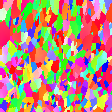

(285.297107951799, 4.1303798153981606e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_IPF.bmp'}


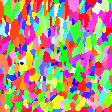

(280.5720425424756, 4.5712965327911616e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_IPF.bmp'}


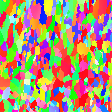

(284.99048736594904, 4.776423241720771e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_IPF.bmp'}


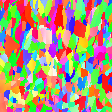

(281.82243068286505, 4.5431716696356826e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_IPF.bmp'}


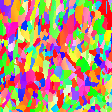

(283.6496989247129, 4.680020300136036e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_IPF.bmp'}


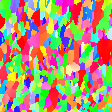

(278.09977942357386, 4.056508872393087e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_IPF.bmp'}


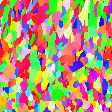

(284.69245693585196, 4.527017090838957e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_IPF.bmp'}


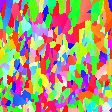

(266.5501430297342, 4.4357845281824486e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_IPF.bmp'}


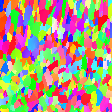

(291.10525712977346, 4.813220482067768e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_IPF.bmp'}


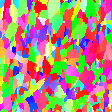

(275.2541115574477, 4.1902181079007046e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_IPF.bmp'}


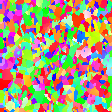

(289.64207933560357, 4.415008438875864e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_IPF.bmp'}


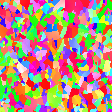

(293.3823363408792, 4.895299687156801e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_IPF.bmp'}


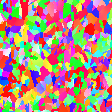

(293.51779648928925, 4.759314601095306e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_IPF.bmp'}


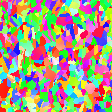

(287.9329189465092, 4.68193845756079e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_IPF.bmp'}


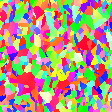

(288.75264972098427, 4.363513757573284e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_IPF.bmp'}


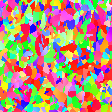

(293.18821149338146, 4.7236018615516205e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_IPF.bmp'}


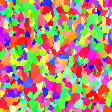

(299.3353233293923, 4.770810950063635e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_IPF.bmp'}


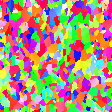

(291.4872610845482, 4.768492295885532e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_IPF.bmp'}


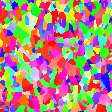

(295.9014787186259, 4.800124280930144e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_IPF.bmp'}


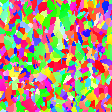

(291.529451512329, 4.287341666111735e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_IPF.bmp'}


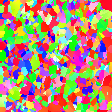

(288.5261646977053, 4.942814698828491e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_IPF.bmp'}


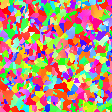

(294.92966869567516, 4.798657429548343e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_IPF.bmp'}


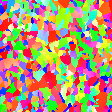

(289.2651624909796, 4.626610129963827e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_IPF.bmp'}


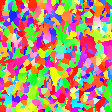

(299.5596268694927, 4.7808656388105555e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_IPF.bmp'}


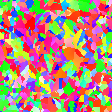

(289.2027956067467, 4.138205193192605e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_IPF.bmp'}


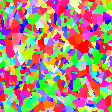

(289.6064514609532, 4.552259274004847e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_IPF.bmp'}


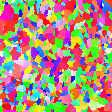

(297.0490384403091, 4.715919411569739e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_IPF.bmp'}


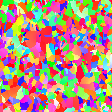

(294.24902784037613, 4.9157544824261843e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_IPF.bmp'}


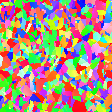

(293.6881060577715, 4.6667900307888685e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_IPF.bmp'}


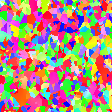

(291.3439168205841, 4.805713943239809e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_IPF.bmp'}


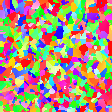

(294.6846003322902, 4.759618816379699e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_IPF.bmp'}


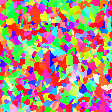

(292.6294892975502, 4.69825208224304e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_IPF.bmp'}


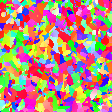

(299.2997316619316, 4.89334438344469e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_IPF.bmp'}


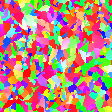

(296.07819695968243, 4.589126964207177e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_IPF.bmp'}


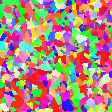

(296.2708735195927, 4.81366943978221e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_IPF.bmp'}


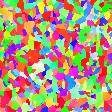

(290.70231636756324, 4.7131880920269114e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_IPF.bmp'}


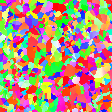

(292.9070083546906, 4.934594695101976e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_IPF.bmp'}


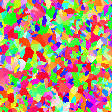

(291.6255997045383, 4.722656766068105e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_IPF.bmp'}


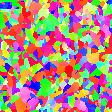

(295.75340036461046, 4.55827014105564e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE22/HGE22_IPF.bmp'}


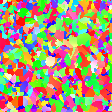

(290.5724140227698, 4.4103538382824403e+17)
HGE22:290.11616530203844,4.630653802220865e+17
  sample_name    mobility  Concentration
0     default    0.000000   0.000000e+00
0       HGE15  235.295383   2.909818e+17
0       HGE20  304.963599   4.679475e+17
0       HGE22  290.116165   4.630654e+17
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_IPF.bmp'}


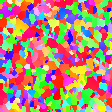

(297.3774104953625, 4.4873824291973126e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_IPF.bmp'}


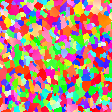

(301.2427633410008, 4.8075990105809984e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_IPF.bmp'}


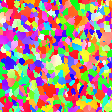

(296.48817096848904, 4.798585271817729e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_IPF.bmp'}


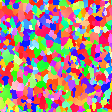

(301.50787238387653, 4.672714223169161e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_IPF.bmp'}


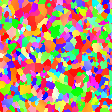

(294.62331061195044, 4.787325036606971e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_IPF.bmp'}


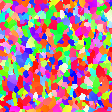

(298.7438245750984, 4.856380411773404e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_IPF.bmp'}


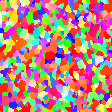

(301.38598087980097, 4.4970906327466394e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_IPF.bmp'}


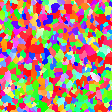

(298.5675136649259, 4.7799267343749325e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_IPF.bmp'}


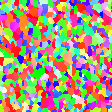

(304.1111059596674, 4.6664868829265254e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_IPF.bmp'}


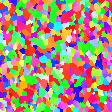

(296.74754117179964, 4.8639200406849286e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_IPF.bmp'}


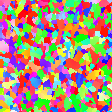

(294.569805437393, 4.711960770153243e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_IPF.bmp'}


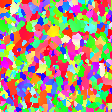

(298.0074789584686, 4.725889347005849e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_IPF.bmp'}


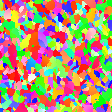

(293.4265272158901, 4.7777007324308134e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_IPF.bmp'}


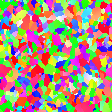

(298.91850616173514, 4.7866903474557414e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_IPF.bmp'}


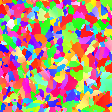

(298.3652059925593, 4.531004766135227e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_IPF.bmp'}


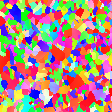

(292.9516699231674, 4.6893117821168454e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_IPF.bmp'}


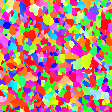

(296.41845402474996, 4.8132847408752083e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_IPF.bmp'}


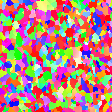

(300.21624425443554, 4.73070704968859e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_IPF.bmp'}


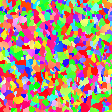

(301.220532126534, 4.790127232973952e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_IPF.bmp'}


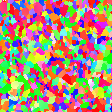

(304.199505813284, 4.184075520968879e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_IPF.bmp'}


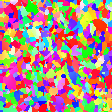

(299.07188886903947, 4.9041232113106714e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_IPF.bmp'}


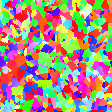

(295.31933952286573, 4.519506922776027e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_IPF.bmp'}


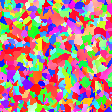

(302.25431075463115, 4.797850244993752e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_IPF.bmp'}


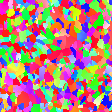

(294.7866412446208, 4.7680012817423014e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_IPF.bmp'}


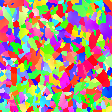

(285.7468102994878, 4.297000341277919e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_IPF.bmp'}


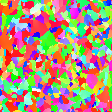

(296.8220917753617, 4.7949692728794445e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_IPF.bmp'}


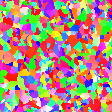

(303.22679061059114, 4.7627294977192755e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_IPF.bmp'}


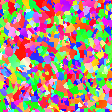

(302.285566611127, 4.831202700899365e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_IPF.bmp'}


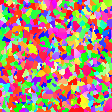

(301.86819728382716, 4.891525282786222e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_IPF.bmp'}


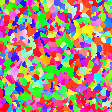

(291.4102212366953, 4.739162099750626e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_IPF.bmp'}


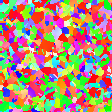

(297.46394567871033, 4.762010268741647e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_IPF.bmp'}


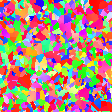

(304.0005473059633, 4.4496783070762086e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_IPF.bmp'}


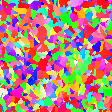

(294.0129298082357, 4.768230350514339e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_IPF.bmp'}


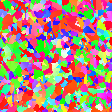

(298.90623192443184, 4.541381602856989e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_IPF.bmp'}


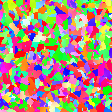

(297.30744010129564, 4.7877793314316646e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_IPF.bmp'}


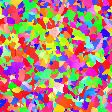

(291.1201744919238, 4.699488797430753e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_IPF.bmp'}


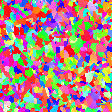

(299.20078646431915, 4.6948568261848e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_IPF.bmp'}


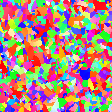

(298.84860818204766, 4.739826036266039e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_IPF.bmp'}


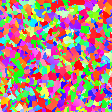

(301.865979593459, 4.807219221815429e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE21/HGE21_IPF.bmp'}


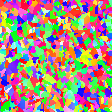

(301.194300017607, 4.893802734473176e+17)
HGE21:298.1450556434107,4.710212682415239e+17
  sample_name    mobility  Concentration
0     default    0.000000   0.000000e+00
0       HGE15  235.295383   2.909818e+17
0       HGE20  304.963599   4.679475e+17
0       HGE22  290.116165   4.630654e+17
0       HGE21  298.145056   4.710213e+17
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_IPF.bmp'}


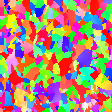

(291.698919263651, 4.8185403000830656e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_IPF.bmp'}


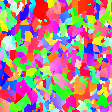

(280.8503762613839, 4.154002399086822e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_IPF.bmp'}


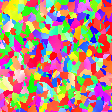

(298.75142808493234, 3.715756798633001e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_IPF.bmp'}


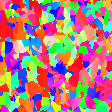

(288.3097090659692, 4.6002048837317094e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_IPF.bmp'}


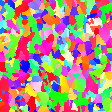

(291.1980923641266, 4.838984207647534e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_IPF.bmp'}


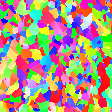

(292.0777188821386, 4.4203570772865254e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_IPF.bmp'}


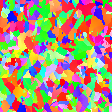

(296.2719778388781, 4.7901374802256365e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_IPF.bmp'}


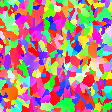

(300.23128834174975, 4.48495895417385e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_IPF.bmp'}


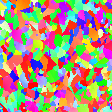

(288.5014170835554, 4.489676319183844e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_IPF.bmp'}


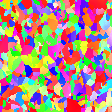

(299.6960917674166, 4.708320007023386e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_IPF.bmp'}


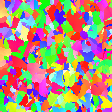

(299.6818261346806, 4.1315502436765376e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_IPF.bmp'}


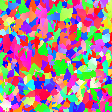

(301.71495035348414, 4.575467804680118e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_IPF.bmp'}


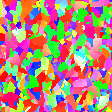

(299.0259872043159, 4.705491552073963e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_IPF.bmp'}


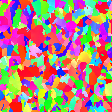

(304.57740025202946, 4.431718931076492e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_IPF.bmp'}


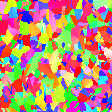

(294.626180031733, 4.641268610014568e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_IPF.bmp'}


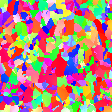

(301.0862849189783, 4.496537281155658e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_IPF.bmp'}


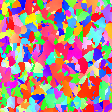

(294.81111730484804, 4.701042109998646e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_IPF.bmp'}


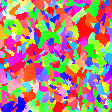

(299.2669007926845, 4.715758017355703e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_IPF.bmp'}


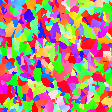

(298.9898795844023, 4.624174059360169e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_IPF.bmp'}


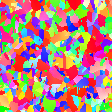

(295.5742381382502, 4.649090038347424e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_IPF.bmp'}


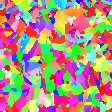

(289.46830292870897, 3.810262717749582e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_IPF.bmp'}


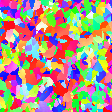

(298.9622172914827, 4.6027427863989856e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_IPF.bmp'}


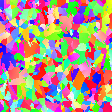

(289.845437016471, 4.655281086240343e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_IPF.bmp'}


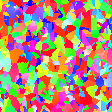

(304.7272618101369, 4.422175750976173e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_IPF.bmp'}


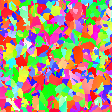

(300.82578324099006, 4.925726339221985e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_IPF.bmp'}


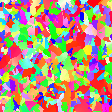

(300.28396980274186, 4.7210251047217056e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_IPF.bmp'}


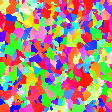

(299.379251702278, 4.7722681946469824e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_IPF.bmp'}


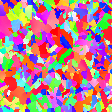

(304.0870643857163, 4.6098851208233126e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_IPF.bmp'}


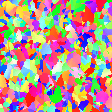

(291.42741965179584, 4.463323376632201e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_IPF.bmp'}


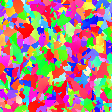

(297.8023380735091, 4.5796858296548864e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_IPF.bmp'}


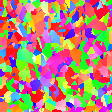

(292.13020120358743, 4.8117474396380736e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_IPF.bmp'}


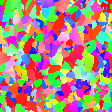

(294.8168199372235, 4.7236046368489517e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_IPF.bmp'}


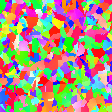

(297.6068283010059, 4.733907821449229e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_IPF.bmp'}


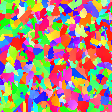

(294.9465865050556, 3.945348820960144e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_IPF.bmp'}


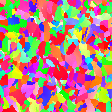

(291.7072831244683, 4.416135423076786e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_IPF.bmp'}


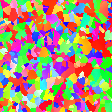

(296.8942527044045, 4.71481889943567e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_IPF.bmp'}


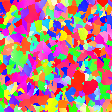

(298.27993806085044, 4.656434329023707e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_IPF.bmp'}


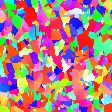

(301.45324478643886, 4.700798737771131e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_IPF.bmp'}


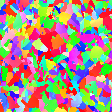

(301.2634829052982, 4.8058226068045504e+17)
{'BC': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_BC.bmp', 'GB': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_GB.bmp', 'IPF': '/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/HGE16/HGE16_IPF.bmp'}


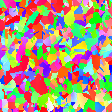

(301.8661606294074, 4.655603020730775e+17)
HGE16:296.6178906932695,4.560490877940496e+17
  sample_name    mobility  Concentration
0     default    0.000000   0.000000e+00
0       HGE15  235.295383   2.909818e+17
0       HGE20  304.963599   4.679475e+17
0       HGE22  290.116165   4.630654e+17
0       HGE21  298.145056   4.710213e+17
0       HGE16  296.617891   4.560491e+17


In [13]:
path_list = glob.glob('/content/drive/MyDrive/03.移動度ML/03.最終版/04.HAGB青_LAGB赤/02.p型/03.極値/03.GB/05.woGB/*')
name_list = ['HGE15', 'HGE20','HGE22','HGE21','HGE16']

path_list_sorted = []
for i in range(len(name_list)):
  for path in path_list:
    if name_list[i] in path:
      path_list_sorted.append(path)
print(path_list_sorted)
path_list = path_list_sorted

ans = {'sample_name':'default',
'mobility':0,
'Concentration':0,
}
d3={}
for k,v in ans.items():   # 一度pd.Seriesに変換
  d3[k]=pd.Series(v)
ans=pd.DataFrame(d3)

for path in path_list:
  preds_list = []
  sample_name = path.split('/')[-1]
  for i in range(4):
    for j in range(10):
      preds = model.predict(path,"cuda:0" if torch.cuda.is_available() else "cpu",mu_range, n_range, [50+int(patch_size*i),int(patch_size*j)])
      img = cv2.imread(f'{path}/{sample_name}_IPF.bmp')
      cv2_imshow(img[50+int(patch_size*i):50+int(patch_size*i)+patch_size,int(patch_size*j):int(patch_size*j)+patch_size])
      print(preds)
      preds_list.append(preds)
      sample_name = path.split('/')[-1]
  preds_list = pd.DataFrame(preds_list)

  d1 = {'sample_name':sample_name,
  'mobility':preds_list[0].mean(),
    'Concentration': preds_list[1].mean(),
  }

  d2={}
  for k,v in d1.items():   # 一度pd.Seriesに変換
      d2[k]=pd.Series(v)

  df=pd.DataFrame(d2)
  ans = pd.concat([ans,df])
  print(f'{path.split("/")[-1]}:{preds_list[0].mean()},{preds_list[1].mean()}')

  print(ans)

In [35]:
#100
ans

sample_name    mobility  Concentration
0     default    0.000000   0.000000e+00
0       HGE15  242.188817   2.900857e+17
0       HGE20  244.240908   3.568604e+17
0       HGE22  273.257108   4.021637e+17
0       HGE21  270.367592   3.972352e+17
0       HGE16  252.036200   3.548165e+17

In [37]:
#110
ans

sample_name    mobility  Concentration
0     default    0.000000   0.000000e+00
0       HGE15  250.609967   3.212983e+17
0       HGE20  250.570237   3.609104e+17
0       HGE22  247.807695   3.628452e+17
0       HGE21  252.392137   3.676485e+17
0       HGE16  252.223255   3.581761e+17

In [39]:
#111
ans

sample_name    mobility  Concentration
0     default    0.000000   0.000000e+00
0       HGE15  200.994261   3.247944e+17
0       HGE20  216.970640   3.915096e+17
0       HGE22  230.709225   3.906567e+17
0       HGE21  228.584789   3.862408e+17
0       HGE16  219.577914   3.697105e+17

In [43]:
#Black
ans

sample_name    mobility  Concentration
0     default    0.000000   0.000000e+00
0       HGE15  194.480740   2.611809e+17
0       HGE20  194.260623   2.652188e+17
0       HGE22  194.055385   2.618404e+17
0       HGE21  191.736027   2.620759e+17
0       HGE16  193.157624   2.612368e+17

In [45]:
#Gray
ans

sample_name    mobility  Concentration
0     default    0.000000   0.000000e+00
0       HGE15  316.193824   4.115536e+17
0       HGE20  218.625511   5.896335e+17
0       HGE22  309.797266   4.371338e+17
0       HGE21  296.446134   4.444674e+17
0       HGE16  324.109166   4.235069e+17

In [47]:
#White
ans

sample_name    mobility  Concentration
0     default    0.000000   0.000000e+00
0       HGE15  285.255525   4.646334e+17
0       HGE20  293.459087   4.694767e+17
0       HGE22  290.887251   4.766230e+17
0       HGE21  293.767928   4.733808e+17
0       HGE16  291.233689   4.741271e+17

In [51]:
#allHAGB
ans

sample_name    mobility  Concentration
0     default    0.000000   0.000000e+00
0       HGE15  194.967206   2.640430e+17
0       HGE20  222.139021   5.852978e+17
0       HGE22  309.975637   4.548671e+17
0       HGE21  314.035766   4.021500e+17
0       HGE16  322.553624   4.219379e+17

In [56]:
#一面HAGB
ans

sample_name    mobility  Concentration
0     default    0.000000   0.000000e+00
0       HGE15  222.204270   2.681938e+17
0       HGE20  217.661665   4.873727e+17
0       HGE22  246.736645   4.513692e+17
0       HGE21  240.187537   4.396889e+17
0       HGE16  216.129312   3.519819e+17

In [58]:
#一面LAGB
ans

sample_name    mobility  Concentration
0     default    0.000000   0.000000e+00
0       HGE15  277.556444   2.611763e+17
0       HGE20  282.050300   2.643133e+17
0       HGE22  263.210395   2.611011e+17
0       HGE21  279.477891   2.611117e+17
0       HGE16  275.249313   2.611059e+17

In [14]:
#woGB
ans

sample_name    mobility  Concentration
0     default    0.000000   0.000000e+00
0       HGE15  235.295383   2.909818e+17
0       HGE20  304.963599   4.679475e+17
0       HGE22  290.116165   4.630654e+17
0       HGE21  298.145056   4.710213e+17
0       HGE16  296.617891   4.560491e+17